### Loading and Inspecting the Data

In [1]:
import pandas as pd
filename = "files/001.csv"
df_all_data = pd.read_csv(filename)

In [2]:
df_all_data

,property,floors,price
0,a,3,1000
1,b,4,1500
2,c,6,3000
3,d,8,3200
4,e,2,1200
5,f,9,4000
6,g,10,4200
7,h,11,5000
8,i,12,5500
9,j,15,7000


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0, 0.5, 'price (USD)')

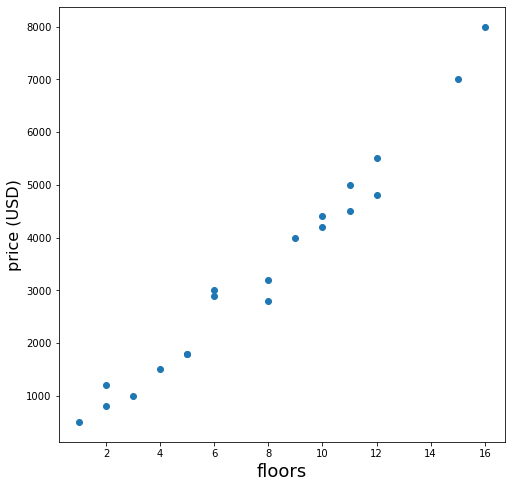

In [4]:
plt.rcParams["figure.figsize"] = (8,8) 
plt.scatter(df_all_data.floors, df_all_data.price)
plt.xlabel('floors', fontsize=18) 
plt.ylabel('price (USD)', fontsize=16) 

### Performing the train-test split

In [5]:
from sklearn.model_selection import train_test_split

X = df_all_data['floors'].values 
y = df_all_data['price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [6]:
X_train

array([10, 10,  2,  6,  9, 11, 15, 11,  1,  5,  8,  3, 12,  8])

In [7]:
y_train

array([4200, 4400, 1200, 3000, 4000, 4500, 7000, 5000,  500, 1800, 3200,
       1000, 4800, 2800])

In [8]:
X_test

array([ 5,  4,  6, 12, 16,  2])

In [9]:
y_test

array([1800, 1500, 2900, 5500, 8000,  800])

### Training and Deploying a KNN model

In [10]:
import sagemaker
from sagemaker import get_execution_role

session = sagemaker.Session()
role = get_execution_role()
bucket = session.default_bucket()

In [11]:
from sagemaker import KNN

estimator = KNN(role=role,
                instance_count=1,
                instance_type='ml.m5.xlarge',
                sample_size=10,
                k=3,
                feature_dim=1,
                predictor_type="regressor")

In [12]:
record_set = estimator.record_set(train=X_train.reshape(-1,1).astype('float32'), labels=y_train.astype('float32'))

In [13]:
estimator.fit(record_set)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-05-08 06:25:26 Starting - Starting the training job...
2021-05-08 06:25:48 Starting - Launching requested ML instancesProfilerReport-1620455125: InProgress
......
2021-05-08 06:26:49 Starting - Preparing the instances for training......
2021-05-08 06:27:49 Downloading - Downloading input data
2021-05-08 06:27:49 Training - Downloading the training image.........
2021-05-08 06:29:25 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[05/08/2021 06:29:14 INFO 140507616921408] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'_kvstore': 'dist_async', '_log_level': 'info', '_num_gpus': 'auto', '_num_kv_servers': '1', '_tuning_objective_metric': '', '_faiss_index_nprobe': '5', 'epochs': '1', 'feature_dim': 'auto', 'faiss_index_ivf_nlists': 'auto', 'index_metric': 'L2', 'index_type': 'faiss.Flat', 'mini_batch_size': '5000', '_enab

In [14]:
predictor = estimator.deploy(initial_instance_count=1,
                             instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------------------------!

In [15]:
payload = X_test.reshape(-1,1).astype('float32')
predictor.predict(payload)

[label {
   key: "predicted_label"
   value {
     float64_tensor {
       values: 2666.6666666666665
     }
   }
 },
 label {
   key: "predicted_label"
   value {
     float64_tensor {
       values: 2000.0
     }
   }
 },
 label {
   key: "predicted_label"
   value {
     float64_tensor {
       values: 2666.6666666666665
     }
   }
 },
 label {
   key: "predicted_label"
   value {
     float64_tensor {
       values: 4633.333333333333
     }
   }
 },
 label {
   key: "predicted_label"
   value {
     float64_tensor {
       values: 5500.0
     }
   }
 },
 label {
   key: "predicted_label"
   value {
     float64_tensor {
       values: 2000.0
     }
   }
 }]

In [16]:
predictor.delete_endpoint()

### Batch Transform

In [17]:
!mkdir -p tmp

In [18]:
import pandas as pd 

pd.DataFrame(X_test.reshape(-1,1)).to_csv("tmp/003.test.csv", header=False, index=False)

In [19]:
!cat tmp/003.test.csv

5
4
6
12
16
2


In [20]:
s3_path = session.upload_data("tmp/003.test.csv")
s3_path

's3://sagemaker-us-east-1-305262579855/data/002.test.csv'

In [21]:
transformer = estimator.transformer(
    instance_count=1,
    instance_type='ml.m5.xlarge',
    strategy='MultiRecord',
    assemble_with='Line')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [22]:
transformer.transform(s3_path, content_type='text/csv', split_type='Line')

....................................
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[05/08/2021 06:49:37 INFO 140197687568192] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
[05/08/2021 06:49:41 WARNING 140197687568192] Loggers have already been setup.
[05/08/2021 06:49:41 INFO 140197687568192] loaded entry point class algorithm.serve.server_config:config_api
[05/08/2021 06:49:41 INFO 140197687568192] loading entry points
[05/08/2021 06:49:41 INFO 140197687568192] loaded request iterator application/json
[05/08/2021 06:49:41 INFO 140197687568192] loaded request iterator application/jsonlines
[05/08/2021 06:49:41 INFO 140197687568192] loaded request iterator application/x-recordio-protobuf
[05/08/2021 06:49:41 INFO 140197687568192] loaded request iterator text/csv
[05/08/2021 06:49:41 INFO 140197687568192] loaded response encoder application/json
[05/08/2021 06:49:41 INFO 140197687568192] loaded response enc

In [23]:
transformer.wait()

Docker entrypoint called with argument(s): serve
Running default environment configuration script
[05/08/2021 06:49:37 INFO 140197687568192] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[05/08/2021 06:49:37 INFO 140197687568192] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
[05/08/2021 06:49:41 WARNING 140197687568192] Loggers have already been setup.
[05/08/2021 06:49:41 INFO 140197687568192] loaded entry point class algorithm.serve.server_config:config_api
[05/08/2021 06:49:41 INFO 140197687568192] loading entry points
[05/08/2021 06:49:41 INFO 140197687568192] loaded request iterator application/json
[05/08/2021 06:49:41 INFO 140197687568192] loaded request iterator application/jsonlines
[05/08/2021 06:49:41 INFO 140197687568192] loaded request iterator application/x-recordio-protobuf
[05/08/2021 06:49:41 INFO 140197687568192]

In [24]:
transformer.output_path

's3://sagemaker-us-east-1-305262579855/knn-2021-05-08-06-43-43-933'

In [25]:
!aws s3 cp {transformer.output_path}/003.test.csv.out tmp/003.test.csv.out

download: s3://sagemaker-us-east-1-305262579855/knn-2021-05-08-06-43-43-933/002.test.csv.out to tmp/002.test.csv.out


In [26]:
cat tmp/003.test.csv.out

{"predicted_label":2666.666666666666515}
{"predicted_label":2000.0}
{"predicted_label":2666.666666666666515}
{"predicted_label":4633.33333333333303}
{"predicted_label":5500.0}
{"predicted_label":2000.0}
